# **Transfer Learning wiht Kaggle Image Data Set and Xception Model**

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"juliamueller14","key":"fc8d261a8aaf29bfb64a5ea64207408c"}'}

In [0]:
!cp kaggle.json ~/.kaggle/
#!kaggle datasets list

#!kaggle datasets list -s [Flowers]
#!kaggle datasets list -s [car]
#!kaggle datasets list -s [data-science-bowl-2018]

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import shutil
import cv2
import numpy as np

try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 1.x
except Exception:
  pass
  
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Input, \
  Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D

TensorFlow 1.x selected.


### **Load Data from Kaggle** (alxmamaev/flowers-recognition)

In [5]:
!kaggle datasets download -d alxmamaev/flowers-recognition
!ls

base_dir, _ = os.path.splitext("./")
print(os.listdir(base_dir))

import zipfile
         
flowers_zip = zipfile.ZipFile('flowers-recognition.zip')
flowers_zip.extractall()

flowers_dir = os.path.join(base_dir, 'flowers')
print(os.listdir(flowers_dir))
sunflower_dir = os.path.join(flowers_dir, 'sunflower')
#print(os.listdir(sunflower_dir))
print('Sunflowers:' + str(len(os.listdir(sunflower_dir))))
daisy_dir = os.path.join(flowers_dir, 'daisy')
#print(os.listdir(daisy_dir))
print('daisy:' + str(len(os.listdir(daisy_dir))))

 98% 443M/450M [00:08<00:00, 64.8MB/s]
100% 450M/450M [00:08<00:00, 57.9MB/s]
flowers-recognition.zip  kaggle.json  sample_data
['.config', 'kaggle.json', 'flowers-recognition.zip', 'sample_data']
['sunflower', 'dandelion', 'tulip', 'flowers', 'daisy', 'rose']
Sunflowers:734
daisy:769


### **Create training and validation directory**

In [6]:
TL_dir = os.path.join(base_dir, "Transfer Learning") 
os.makedirs(TL_dir, exist_ok = True) 

# create train directory 
train_dir = os.path.join(TL_dir, "train") 
os.makedirs(train_dir, exist_ok = True)
# copy sunflowers to train
train_sunflower = os.path.join(train_dir, "sunflower") 
if not os.path.exists(train_sunflower) or len(os.listdir(train_sunflower)) == 0:
  shutil.copytree(sunflower_dir, train_sunflower)
# copy daisy to train
train_daisy = os.path.join(train_dir, "daisy") 
if not os.path.exists(train_daisy) or len(os.listdir(train_daisy)) == 0:
  shutil.copytree(daisy_dir, train_daisy)

# create validation directory 
validation_dir = os.path.join(TL_dir, "validation") 
os.makedirs(validation_dir, exist_ok = True)
validation_sunflower = os.path.join(validation_dir, "sunflower")
os.makedirs(validation_sunflower, exist_ok = True)
validation_daisy = os.path.join(validation_dir, "daisy")
os.makedirs(validation_daisy, exist_ok = True)

# split data in train and validation
dir_len = len(os.listdir(train_sunflower))
while 500 < dir_len:
  srcname = os.path.abspath(train_sunflower) +'/'+ os.listdir(train_sunflower)[-1]
  shutil.move(srcname, validation_sunflower)
  dir_len = len(os.listdir(train_sunflower))


dir_len = len(os.listdir(train_daisy))
while 500 < dir_len:
  srcname = os.path.abspath(train_daisy) +'/'+ os.listdir(train_daisy)[-1]
  shutil.move(srcname, validation_daisy)
  dir_len = len(os.listdir(train_daisy))

print('validation_sunflower:' + str(len(os.listdir(validation_sunflower))) + '    train_sunflower:' + str(len(os.listdir(train_sunflower))))
print('validation_daisy:' + str(len(os.listdir(validation_daisy))) + '    train_daisy:' + str(len(os.listdir(train_daisy))))

validation_sunflower:234    train_sunflower:500
validation_daisy:269    train_daisy:500


### **Show images (optional)**

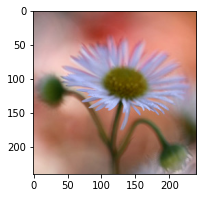

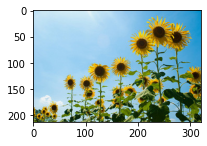

In [7]:
import pandas as pd,numpy as np,pylab as pl


def show_flower(flower_dir: str) -> None:
  n=np.random.randint(0,499,1)[0]
  #print('Label: ', flower_labels)
  srcname = os.path.abspath(flower_dir) +'/'+ os.listdir(flower_dir)[n]
  img=cv2.imread(srcname)
  rgb_img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  pl.figure(figsize=(3,3))
  pl.imshow(rgb_img);

show_flower(train_daisy)
show_flower(train_sunflower)

# **Alternative I**
## **Transfer learning model with Xception pre-train model and a new Fully-Connected-Classifier**
*   ### **without fine-tuning**
*   ### **without data augmentation**
*   ### **Learning rate lr = 0.01**

## **Data preprocessing**

In [8]:
image_size = 224 # All images will be resized to 224x224
batch_size = 32

# Rescale all images by 1./255
train_datagen_I = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_datagen_I = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator_I = train_datagen_I.flow_from_directory(
                train_dir,  # Source directory for the training images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                # Since we use binary_crossentropy loss, we need binary labels
                class_mode='binary',
                shuffle=True)

# Flow validation images in batches of 32 using test_datagen generator
validation_generator_I = validation_datagen_I.flow_from_directory(
                validation_dir, # Source directory for the validation images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='binary',
                shuffle=True)

Found 1000 images belonging to 2 classes.
Found 503 images belonging to 2 classes.


## **Build and train a transfer learning model**


In [9]:
n_classes = 2
# build a transfer learning model with Xception and a new Fully-Connected-Classifier
IMG_SHAPE = (image_size, image_size, 3)
feature_extractor_I = Xception(
    input_shape=IMG_SHAPE,
    weights='imagenet',
    include_top=False
)

for layer in feature_extractor_I.layers:
  layer.trainable = False


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
83689472/83683744 [==============================] - 8s 0us/step


In [10]:
# add a global 2D average pooling layer here
# add Dropout

model_I = tf.keras.Sequential([
  feature_extractor_I,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(1, activation='sigmoid')
])

model_I.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_I.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 2,049
Non-trainable params: 20,861,480
_________________________________________________________________


In [11]:
# Saving the model
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
os.makedirs(checkpoint_dir, exist_ok = True)
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_training_xception_I")


checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

epochs = 25 
# the pretrained model ckpt_training_xception_I has been trained for: 
# 5  epochs reaching a validation accuracy of:0.8875
# 15  epochs reaching a validation accuracy of:0.8438
# 25  epochs reaching a validation accuracy of:0.8792
steps_per_epoch = train_generator_I.n // batch_size
validation_steps = validation_generator_I.n // batch_size

historyI = model_I.fit_generator(train_generator_I,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              validation_data=validation_generator_I,
                              validation_steps=validation_steps,
                              callbacks=[checkpoint_callback])

Epoch 1/25
31/31 [==============================] - 18s 591ms/step - loss: 0.5182 - acc: 0.7996 - val_loss: 0.5399 - val_acc: 0.7750
Epoch 2/25
31/31 [==============================] - 8s 260ms/step - loss: 0.2498 - acc: 0.9039 - val_loss: 1.2817 - val_acc: 0.6479
Epoch 3/25
31/31 [==============================] - 8s 258ms/step - loss: 0.2287 - acc: 0.8946 - val_loss: 1.2076 - val_acc: 0.6771
Epoch 4/25
31/31 [==============================] - 8s 258ms/step - loss: 0.2013 - acc: 0.9329 - val_loss: 0.6497 - val_acc: 0.7958
Epoch 5/25
31/31 [==============================] - 8s 258ms/step - loss: 0.1658 - acc: 0.9401 - val_loss: 0.3498 - val_acc: 0.8792
Epoch 6/25
31/31 [==============================] - 8s 261ms/step - loss: 0.1595 - acc: 0.9375 - val_loss: 0.3114 - val_acc: 0.9146
Epoch 7/25
31/31 [==============================] - 8s 254ms/step - loss: 0.1317 - acc: 0.9544 - val_loss: 0.5345 - val_acc: 0.8354
Epoch 8/25
31/31 [==============================] - 8s 259ms/step - loss: 0

# **Alternative II**
## **Transfer learning model with Xception pre-train model and a new Fully-Connected-Classifier**
*   ### **wit fine-tuning**
*   ### **with data augmentation**
*   ### **Learning rate lr = 0.0001**

## **Data preprocessing**

In [12]:
image_size = 224 # All images will be resized to 224x224
batch_size = 32

# Create an image generator with different data augmentation techniques
train_datagen_II = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.3,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=True
)
validation_datagen_II = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator_II = train_datagen_II.flow_from_directory(
                train_dir,  # Source directory for the training images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                # Since we use binary_crossentropy loss, we need binary labels
                class_mode='binary',
                shuffle=True)

# Flow validation images in batches of 20 using test_datagen generator
validation_generator_II = validation_datagen_II.flow_from_directory(
                validation_dir, # Source directory for the validation images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='binary',
                shuffle=True)

Found 1000 images belonging to 2 classes.
Found 503 images belonging to 2 classes.


**Show augmented images (optional)**

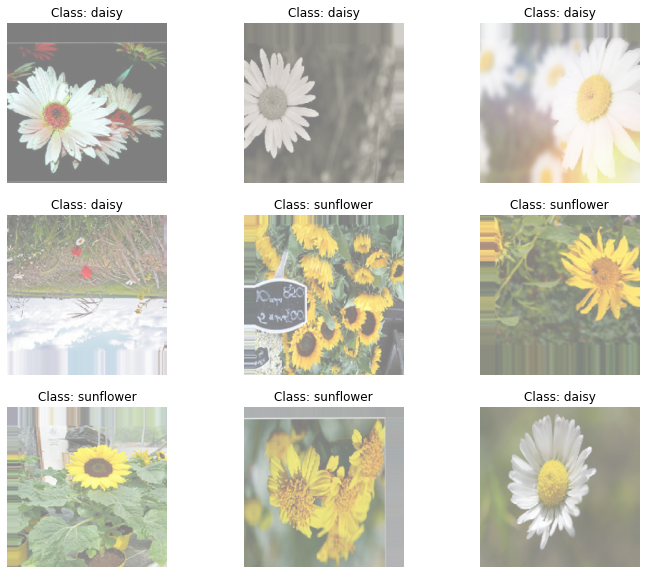

In [13]:
import typing
def plot_images_with_labels(
    images: typing.List[int], labels: np.ndarray, class_names: typing.List[str]
) -> None:
    if len(images) != 9:
        images = images[:9]
        labels = labels[:9]
    labels = labels.astype("int")

    plt.figure(figsize=(12, 10))
    index = 0
    for image, label in zip(images, labels):
        index += 1
        plt.subplot(3, 3, index)
        plt.imshow(image)
        plt.title("Class: {}".format(class_names[label]))
        plt.axis("off")

# plot some augmented images

X_augmented, y_augmented = next(train_generator_II)
plot_images_with_labels((X_augmented + 1) / 2, y_augmented, ["daisy","sunflower"])

## **Build and train a transfer learning model**


In [0]:
n_classes = 2
# build a transfer learning model with Xception and a new Fully-Connected-Classifier
IMG_SHAPE = (image_size, image_size, 3)
feature_extractor_II = Xception(
    input_shape=IMG_SHAPE,
    weights='imagenet',
    include_top=False
)

for layer in feature_extractor_II.layers:
  layer.trainable = True


In [15]:
# add a global 2D average pooling layer here
# add Dropout

model_II = tf.keras.Sequential([
  feature_extractor_II,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(1, activation='sigmoid')
])

model_II.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_II.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 20,809,001
Non-trainable params: 54,528
_________________________________________________________________


In [16]:
# Saving the model
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
os.makedirs(checkpoint_dir, exist_ok = True)
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_training_xception_II")


checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

epochs = 25 
# the pretrained model ckpt_training_xception_II has been trained for: 
# 5  epochs reaching a validation accuracy of:0.9771
# 15  epochs reaching a validation accuracy of:0.9729
# 25  epochs reaching a validation accuracy of:0.9750
steps_per_epoch = train_generator_II.n // batch_size
validation_steps = validation_generator_II.n // batch_size

historyII = model_II.fit_generator(train_generator_II,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              validation_data=validation_generator_II,
                              validation_steps=validation_steps,
                              callbacks=[checkpoint_callback])

Epoch 1/25
31/31 [==============================] - 44s 1s/step - loss: 0.3203 - acc: 0.8843 - val_loss: 0.1258 - val_acc: 0.9500
Epoch 2/25
31/31 [==============================] - 29s 934ms/step - loss: 0.1115 - acc: 0.9690 - val_loss: 0.0869 - val_acc: 0.9688
Epoch 3/25
31/31 [==============================] - 29s 935ms/step - loss: 0.0783 - acc: 0.9721 - val_loss: 0.0748 - val_acc: 0.9750
Epoch 4/25
31/31 [==============================] - 29s 941ms/step - loss: 0.0388 - acc: 0.9897 - val_loss: 0.0703 - val_acc: 0.9688
Epoch 5/25
31/31 [==============================] - 29s 940ms/step - loss: 0.0306 - acc: 0.9928 - val_loss: 0.0721 - val_acc: 0.9771
Epoch 6/25
31/31 [==============================] - 29s 934ms/step - loss: 0.0175 - acc: 0.9928 - val_loss: 0.0821 - val_acc: 0.9771
Epoch 7/25
31/31 [==============================] - 29s 935ms/step - loss: 0.0121 - acc: 0.9969 - val_loss: 0.0594 - val_acc: 0.9750
Epoch 8/25
31/31 [==============================] - 29s 937ms/step - los

# **Alternative III**
## **Transfer learning model with Xception pre-train model and a new Fully-Connected-Classifier**
*   ### **with fine-tuning**
*   ### **without data augmentation**
*   ### **Learning rate lr = 0.0001**

## **Data preprocessing**

In [17]:
image_size = 224 # All images will be resized to 224x224
batch_size = 32

# Create an image generator
train_datagen_III = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_datagen_III = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator_III = train_datagen_III.flow_from_directory(
                train_dir,  # Source directory for the training images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                # Since we use binary_crossentropy loss, we need binary labels
                class_mode='binary',
                shuffle=True)

# Flow validation images in batches of 32 using test_datagen generator
validation_generator_III = validation_datagen_III.flow_from_directory(
                validation_dir, # Source directory for the validation images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='binary',
                shuffle=True)

Found 1000 images belonging to 2 classes.
Found 503 images belonging to 2 classes.


## **Build and train a transfer learning model**


In [0]:
n_classes = 2
# build a transfer learning model with Xception and a new Fully-Connected-Classifier
IMG_SHAPE = (image_size, image_size, 3)
feature_extractor_III = Xception(
    input_shape=IMG_SHAPE,
    weights='imagenet',
    include_top=False
)

for layer in feature_extractor_III.layers:
  layer.trainable = True


In [19]:
# add a global 2D average pooling layer here
# add Dropout

model_III = tf.keras.Sequential([
  feature_extractor_III,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(1, activation='sigmoid')
])

model_III.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_III.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 20,809,001
Non-trainable params: 54,528
_________________________________________________________________


In [20]:
# Saving the model
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
os.makedirs(checkpoint_dir, exist_ok = True)
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_training_xception_III")


checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

epochs = 25 
# the pretrained model ckpt_training_xception_III has been trained for: 

# 5  epochs reaching a validation accuracy of:0.9667
# 15  epochs reaching a validation accuracy of:0.9688
# 25  epochs reaching a validation accuracy of:0.9771
steps_per_epoch = train_generator_III.n // batch_size
validation_steps = validation_generator_III.n // batch_size

historyIII = model_III.fit_generator(train_generator_III,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              # callbacks=[checkpoint_callback],
                              validation_data=validation_generator_III,
                              validation_steps=validation_steps)

Epoch 1/25
31/31 [==============================] - 41s 1s/step - loss: 0.2707 - acc: 0.9153 - val_loss: 0.1425 - val_acc: 0.9458
Epoch 2/25
31/31 [==============================] - 29s 926ms/step - loss: 0.0680 - acc: 0.9866 - val_loss: 0.0885 - val_acc: 0.9646
Epoch 3/25
31/31 [==============================] - 29s 923ms/step - loss: 0.0151 - acc: 0.9979 - val_loss: 0.0877 - val_acc: 0.9625
Epoch 4/25
31/31 [==============================] - 28s 911ms/step - loss: 0.0035 - acc: 1.0000 - val_loss: 0.0987 - val_acc: 0.9667
Epoch 5/25
31/31 [==============================] - 29s 921ms/step - loss: 0.0010 - acc: 1.0000 - val_loss: 0.0994 - val_acc: 0.9667
Epoch 6/25
31/31 [==============================] - 29s 921ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.1408 - val_acc: 0.9521
Epoch 7/25
31/31 [==============================] - 29s 942ms/step - loss: 0.0062 - acc: 0.9990 - val_loss: 0.1234 - val_acc: 0.9729
Epoch 8/25
31/31 [==============================] - 28s 904ms/step - los

In [21]:
print(os.listdir(checkpoint_dir))

['ckpt_training_xception_I.data-00001-of-00002', 'checkpoint', 'ckpt_training_xception_II.data-00000-of-00002', 'ckpt_training_xception_I.index', 'ckpt_training_xception_II.data-00001-of-00002', 'ckpt_training_xception_I.data-00000-of-00002', 'ckpt_training_xception_II.index']


In [0]:
def plot_learning_curve(
    title: str, x: int, y: int, y_test: int, ylim: float = 0.6
) -> None:
    plt.figure()
    plt.title(title)
    axes = plt.gca()
    axes.set_ylim([ylim, 1])
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    train_sizes = x
    train_scores = y
    test_scores = y_test

    plt.grid()

    plt.plot(
        train_sizes,
        train_scores,
        "o-",
        color=(177 / 255, 6 / 255, 58 / 255),
        label="Training accuracy",
    )
    plt.plot(
        train_sizes,
        test_scores,
        "o-",
        color=(246 / 255, 168 / 255, 0),
        label="Validation accuracy",
    )

    plt.legend(loc="best")


def plot_history(title: str, history: "History", ylim: float = 0.6) -> None:
    y = history.history["acc"]
    y_test = history.history["val_acc"]
    plot_learning_curve(title, np.arange(1, 1 + len(y)), y, y_test, ylim)



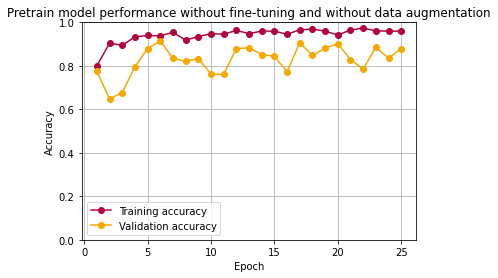

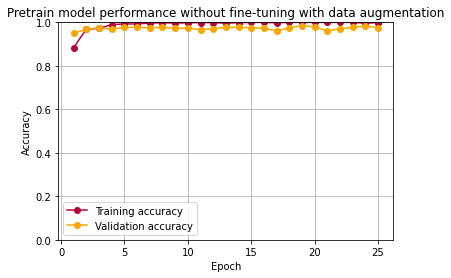

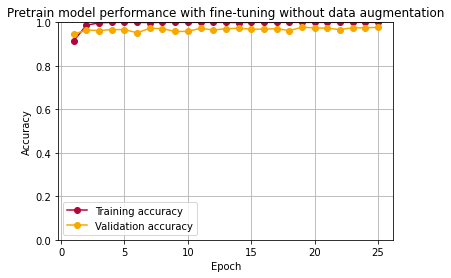

In [23]:
plot_history('Pretrain model performance without fine-tuning and without data augmentation', historyI, 0)
plot_history('Pretrain model performance with fine-tuning with data augmentation', historyII, 0)
plot_history('Pretrain model performance with fine-tuning without data augmentation', historyIII, 0)

# **Ergebnisse**
### **Auswahl des Modells und des Datasets**
In diesem Notebook zum Testen der Transfer-Learning habe ich das **Xception Modell** ausgewählt, weil mich ein Model mit separablen Convolutions (Depthwise und Pointwise) interessiert hat. 
Als Dataset habe ich mir von **Kaggle** den **"alxmamaev/flowers-recognition"** Dataset geladen. Für die binäre Klassifikation habe ich nur die "Sunflower"- und "Daisy"-Bilder benutzt. Bei diesem kleinen Dataset (insg. 1000 Trainingsdaten und 500 Validierungsdaten) bietet sich Transfer-Learning besonders gut an. Ein pretrainirtes Netz, das gelernt hat, wie Objekte "unserer Welt" gut unterschieden werden können, kann das Wissen darüber sehr gut für die Klassifizierung neuer Objekte verwenden und beim Trainieren mit wenig Bilddaten gute Ergebnisse erzielen.
### **Test-Varianten** 
Es wurde 3 unterschiedliche Kombinationen der Parameter ausprobiert. In allen 3 Varianten wurde Dropout als Regularisierungs-Technik verwendet. Alle 3 Varianten sind 25 Epochen durchlaufen.
### **Variante I** 
Hier wurde nur der neuer Classifier trainiert, das Basis-Modell ist "eigefroren" geblieben. Kein Finetuning des gesamten Netzes und keine andere Regularisierungstechnik außer Dropout wurde angewendet. Die Lernrate wurde auf 0.01 gesetzt. Es wurden die gleiche Parameter für den Classifier wie beim VGG16 Modell im Toutorial Notbook benutzt. Das Xception-Netz hat durchschnittlich die bessere Accuracy erreicht. Aber bei der hohen Lernrate waren die Ergebnisse sehr unstabil (Siehe Plot).  

### **Variante II** 
Es wurde das Finetuning des gesamten Netzes, eine zusätzliche Regularisierungstechnik (Data Augmentation) angewendet und vor allem die Lernrate wurde auf 0.0001 reduziert. Das Modell hat bereits ab der 5. Epoche beinahe perfekte Ergebnisse gezeigt: Validation accuracy ca 0.97, der Unterschied zwischen Trainings- und Validation-Accuracy ist gering. Den größten Einfluß auf die Ergebnisse hat die stark reduzierte Lernrate gemacht (Siehe Plot).

### **Variante III** 
Es wurde die Variante II, aber ohne Data Augmentation als eine zusätzliche Regularisierungstechnik angewendet. Man merkt, dass ohne Data Augmentation der Abstand zwischen den Kurven von Trainings und Validation-Accuracy etwas größer ist als mit. Somit ist die regularisierende Wirkung von Data Augmentation spürbar, aber nicht ausschlaggebend.  


Wenn man ein Netz für einen Dataset mit wenig Bider trainiren muss, erreicht man mit Xception (auch ohne Finetuning) in der kürzeste Zeit sehr gute Ergebnisse.